In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from opendp.mod import binary_search, binary_search_param, enable_features

from tools import *

enable_features('contrib')
enable_features('floating-point')

In [ ]:
def squared_loss(theta, x, y):
    n = len(x)
    return (1 / n) * np.sum((theta * x - y) ** 2)

def d_squared_loss(theta, x, y):
    n = len(x)
    return (2 / n) * np.sum((theta * x - y) * x)

def calc_lipschitz_coeff(x, y):
    return np.linalg.norm(x) ** 2 + np.linalg.norm(x) * np.linalg.norm(y)

def lasso_regression(x, y, bounds=(-1., 1.), T=100):
    n = len(x)
    # Dealing only with simple, 1D case
    theta = np.random.choice(bounds)
    s1, s2 = bounds
    for t in range(T):
        # as we are in the 1D case, there are only two points in the hull to consider: the bounds
        loss_1 = s1 * d_squared_loss(theta, x, y)
        loss_2 = s2 * d_squared_loss(theta, x, y)
        choice = s1
        if loss_2 < loss_1:
            choice = s2
        mu_t = 2 / (t+2)
        theta = (1-mu_t)*theta + mu_t*choice
    return theta
        
def dp_lasso_regression(x, y, epsilon, delta = 10. ** (-5), T=100, bounds=(-1., 1.), C_1=1., L_1=10., dim=1):
    assert(len(x) == len(y))
    n = len(x)
    # Dealing only with simple, 1D case
    if dim != 1:
        print("Data is not 1D")
        return 
    # L_1 = calc_lipschitz_coeff(x, y)
    theta = np.random.choice(bounds)
    s1, s2 = bounds
    noise_scale = (L_1 * C_1 * np.sqrt(8 * T * np.log(1./delta))) / (n * epsilon)
    for t in range(T):
        # as we are in the 1D case, there are only two points in the hull to consider: the bounds
        loss_1 = s1 * d_squared_loss(theta, x, y) + laplace(scale=noise_scale)
        loss_2 = s2 * d_squared_loss(theta, x, y) + laplace(scale=noise_scale)
        choice = s1
        if loss_2 < loss_1:
            choice = s2
        mu_t = 2 / (t+2)
        theta = (1-mu_t)*theta + mu_t*choice
    return theta
        


In [ ]:
epsilon, delta = 1., 10. ** (-5)
trials = 100

# change true from OLS to lasso too?
true_sd, true_bias, dp_sd, dp_bias = [], [], [], []
lasso_sd, lasso_bias = [], []

for n in range(100, 5001, 100):
    slope = 0.
    true_ols, dp_ols = [], []
    true_lasso = []
    for _ in range(trials):
        x = np.random.uniform(-1., 1., n)
        y = clamp(slope * x + np.random.normal(loc=0., scale=0.02, size=n), (-1, 1))
        # true_ols.append(ols_regression(x, y))
        # true_lasso.append(lasso_regression(x, y))
        dp_ols.append(dp_lasso_regression(x, y, epsilon, delta))
    # true_sd.append(np.std(true_ols))
    # true_bias.append(np.mean(true_ols) - slope)
    # lasso_sd.append(np.std(true_lasso))
    # lasso_bias.append(np.mean(true_lasso) - slope)
    dp_sd.append(np.std(dp_ols))
    dp_bias.append(np.mean(dp_ols) - slope)

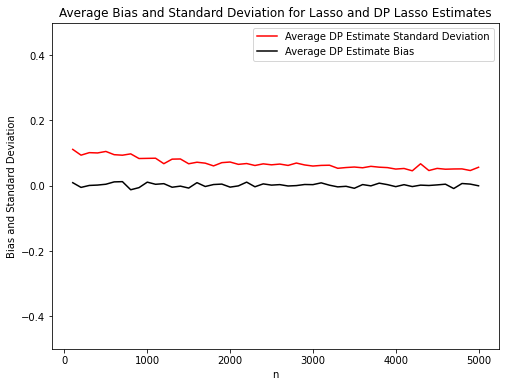

In [ ]:
plot_true_sd = clamp(true_sd, (-1, 1))
plot_true_bias = clamp(true_bias, (-1, 1))
plot_dp_sd = clamp(dp_sd, (-1, 1))
plot_dp_bias = clamp(dp_bias, (-1, 1))

plt.figure(figsize=(8, 6))

# plt.plot(list(range(100, 5001, 100)), lasso_sd, color="green", label="Average True Lasso Standard Deviation")
# plt.plot(list(range(100, 5001, 100)), lasso_bias, color="blue", label="Average True Lasso Bias")
plt.plot(list(range(100, 5001, 100)), plot_dp_sd, color="red", label="Average DP Estimate Standard Deviation")
plt.plot(list(range(100, 5001, 100)), plot_dp_bias, color="black", label="Average DP Estimate Bias")

plt.xlabel("n")
plt.ylim(-0.5, 0.5)
plt.ylabel("Bias and Standard Deviation")
plt.title("Average Bias and Standard Deviation for Lasso and DP Lasso Estimates")
plt.legend()
plt.show()

In [ ]:
x = np.random.uniform(-0.5, 0.5, 100)
y = clamp(slope * x + np.random.normal(loc=0., scale=0.02, size=100), (-1, 1))
print(np.transpose(x) @ x)
print(np.transpose(x) @ y)

9.175459620030635
-9.249853674869126


In [ ]:
N = 2000
trials = 100
delta = 10 ** (-5)
slope = 0.5

lasso_sd, lasso_bias, dp_sd, dp_bias = [], [], [], []

sigmas = np.arange(0.02, 0.5, 0.01)
for sigma in sigmas:
    true_lasso, dp_lasso = [], []
    for _ in range(trials):
        x = np.random.uniform(-1., 1., N)
        y = clamp(slope * x + np.random.normal(loc=0., scale=sigma, size=N), (-1, 1))
        true_lasso.append(lasso_regression(x, y))
        dp_lasso.append(dp_lasso_regression(x, y, epsilon, delta))
    lasso_sd.append(np.std(true_lasso))
    lasso_bias.append(np.mean(true_lasso) - slope)
    dp_sd.append(np.std(dp_lasso))
    dp_bias.append(np.mean(dp_lasso) - slope)


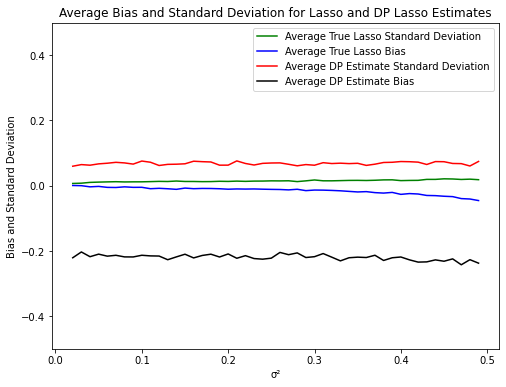

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(np.arange(0.02, 0.5, 0.01), lasso_sd, color="green", label="Average True Lasso Standard Deviation")
plt.plot(np.arange(0.02, 0.5, 0.01), lasso_bias, color="blue", label="Average True Lasso Bias")
plt.plot(np.arange(0.02, 0.5, 0.01), dp_sd, color="red", label="Average DP Estimate Standard Deviation")
plt.plot(np.arange(0.02, 0.5, 0.01), dp_bias, color="black", label="Average DP Estimate Bias")

plt.xlabel("σ²")
plt.ylim(-0.5, 0.5)
plt.ylabel("Bias and Standard Deviation")
plt.title("Average Bias and Standard Deviation for Lasso and DP Lasso Estimates")
plt.legend()
plt.show()

In [ ]:
N = 2000
trials = 100
delta = 10 ** (-5)
slope = 0.5

lasso_sd, lasso_bias, dp_sd, dp_bias = [], [], [], []

epsilons = np.logspace(-1, 1, 50)
for epsilon in epsilons:
    true_lasso, dp_lasso = [], []
    for _ in range(trials):
        x = np.random.uniform(-1., 1., N)
        y = clamp(slope * x + np.random.normal(loc=0., scale=0.1, size=N), (-1, 1))
        true_lasso.append(lasso_regression(x, y))
        dp_lasso.append(dp_lasso_regression(x, y, epsilon, delta))
    lasso_sd.append(np.std(true_lasso))
    lasso_bias.append(np.mean(true_lasso) - slope)
    dp_sd.append(np.std(dp_lasso))
    dp_bias.append(np.mean(dp_lasso) - slope)

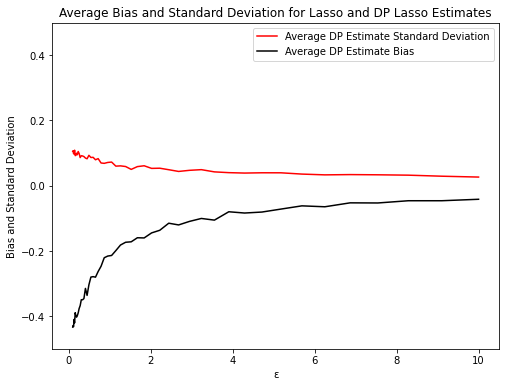

In [ ]:
plt.figure(figsize=(8, 6))

# plt.plot(np.logspace(-1, 1, 50), lasso_sd, color="green", label="Average True Lasso Standard Deviation")
# plt.plot(np.logspace(-1, 1, 50), lasso_bias, color="blue", label="Average True Lasso Bias")
plt.plot(np.logspace(-1, 1, 50), dp_sd, color="red", label="Average DP Estimate Standard Deviation")
plt.plot(np.logspace(-1, 1, 50), dp_bias, color="black", label="Average DP Estimate Bias")

plt.xlabel("ε")
plt.ylim(-0.5, 0.5)
plt.ylabel("Bias and Standard Deviation")
plt.title("Average Bias and Standard Deviation for Lasso and DP Lasso Estimates")
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5d71c9c3-da98-48cf-bf84-cbaf5507821e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>